In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

#### set batchsize

In [3]:
bs = 32

## load data

#### there's this URLs thing which got a bunch of paths for fastai-based image datasets. Using the path, we can use untar_data to download the data

In [4]:
path = untar_data(URLs.PETS); path

WindowsPath('C:/Users/htngu/.fastai/data/oxford-iiit-pet')

#### path.ls() works like ls in linux

In [5]:
path.ls()

[WindowsPath('C:/Users/htngu/.fastai/data/oxford-iiit-pet/annotations'),
 WindowsPath('C:/Users/htngu/.fastai/data/oxford-iiit-pet/images')]

In [6]:
path_anno = path/'annotations'
path_img = path/'images'

In [7]:
fnames = get_image_files(path_img)
fnames[:5]

[WindowsPath('C:/Users/htngu/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('C:/Users/htngu/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('C:/Users/htngu/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('C:/Users/htngu/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),
 WindowsPath('C:/Users/htngu/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg')]

In [8]:
pat = r'/([^/]+)_\d+.jpg$'

In [9]:
pat = re.compile(pat)
res = pat.search('/Abyssinian_102.jpg')
res.group(1)

'Abyssinian'

#### model pretrained on Imagenet hence normalize according to imagenet stats

In [10]:
data = ImageDataBunch.from_name_re(path_img, fnames
                                   , pat, ds_tfms=get_transforms()
                                   , size=224
                                   , bs=bs
                                  ).normalize(imagenet_stats)

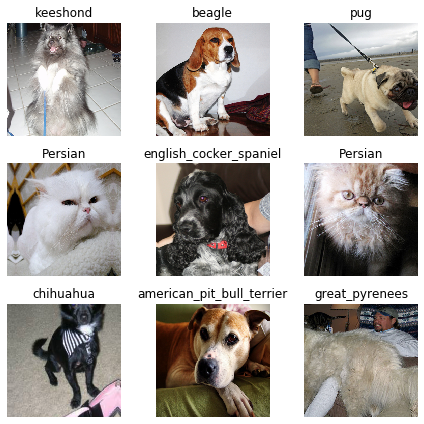

In [11]:
data.show_batch(rows=3, figsize=(6,6))

#### the labels are...

In [12]:
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [13]:
len(data.classes), data.c

(37, 37)

### training a model: using a resnet

Q&A: Why resnet you ask, instead of say Inception? well, resnet is good enough. It seems to work well across various datasets, so it's a good starting point

In [17]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [18]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### fitting the model: cyclicLR is magic

In [19]:
learn.fit_one_cycle(4,  )

epoch,train_loss,valid_loss,error_rate,time
0,0.972232,0.321485,0.106901,01:57
1,0.589483,0.224178,0.077808,01:57
2,0.423346,0.228686,0.074425,01:57
3,0.292630,0.197008,0.059540,02:03


In [18]:
learn.save('resnet34-stage-1')

### results

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
losses, indices = interp.top_losses()

#### examples that the model is very confident about but got wrong

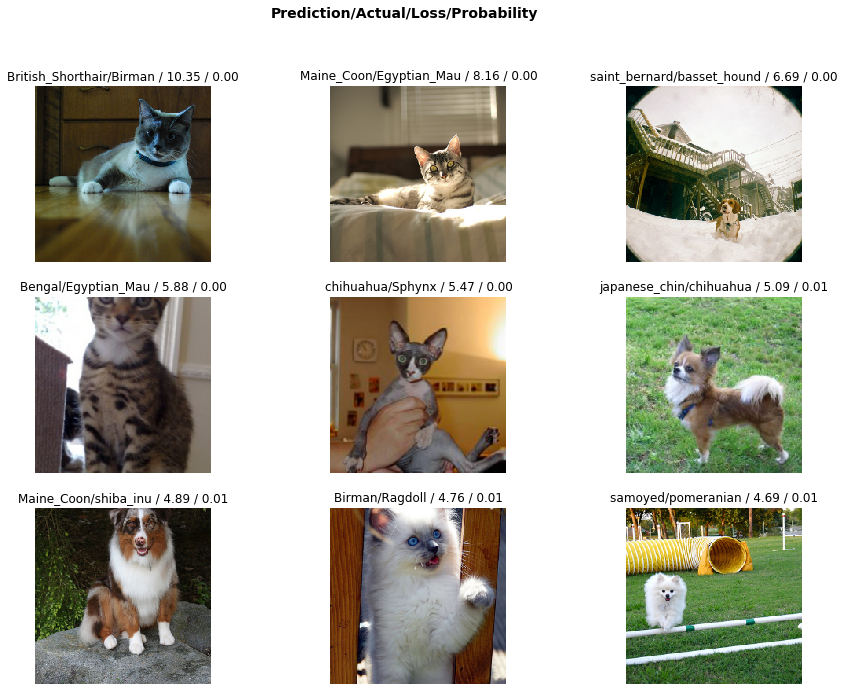

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

#### or most common misclassification

In [26]:
interp.most_confused(min_val=3)

[('Egyptian_Mau', 'Bengal', 8),
 ('Ragdoll', 'Birman', 8),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3)]

## unfreezing and fine-tuning

Having somewhat fine-tuned the classifying head, we could improve the model by retraining the entire model. We first unfreeze all parameters of the model.

In [27]:
learn.unfreeze()

In [ ]:
# learn.load('')

However, blindly retraining the model with the usual learning rate ranges e.g. 0.01, 0.003 will end in tears. Because we actually don't want to change the early layers too much. Instead we want to train the last layers a bit more. This is the idea behind Discriminative Learning Rates - where different blocks of the model get trained with a different learning rate.

To this end, let's look for a suitable learning rate.

In [28]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


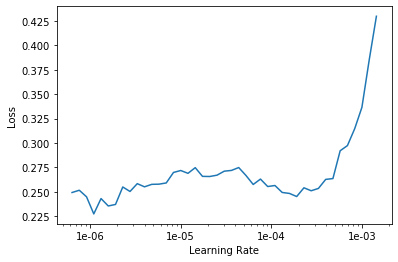

In [29]:
learn.recorder.plot()

So a learning rate at say 1e-3 won't help much. Instead we need lower learning rates. A good rule of thumb is the max_lr is about 10 times lower than the one we used to fine-tune the head - and the min lr way before the learning starts to deteriorate. The following code kinds of distributes the learning rate within the range on the layers of the model. The earlier the layer, the smaller the learning rate

In [30]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.296117,0.192956,0.062923,02:09
1,0.247221,0.193423,0.061570,02:12


here, retraining the entire network doesn't improve the model much here, but the point stands. These steps might not win competitions - they won't. But in production they give a damn good version.

Alternatively, we can change to a bigger version of resnet e.g. resnet34, resnet50 etc which would require a more generous gpu or more modest bs.